In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot 
import scipy.optimize as opt
import os

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

In [5]:
 def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data[:,0:len(freq)], cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [7]:
def demodulate_signal(odmr_data, mod_freq, dwell_time):
    # For lock-in detection to work, I am going to need to demodulate the 
    # signal recorded by multiplying it by a sine wave with a frequency of mod_freq.
    time = np.arange(0, dwell_time*(len(odmr_data[1,:])), dwell_time)
    p0 = [np.mean(odmr_data), mod_freq, np.pi/4, 0]
    x, y = odmr_data.shape
    demod_signal = pd.DataFrame()
    
    for i in range(len(odmr_data)):
        mod_signal_params, confidence = opt.curve_fit(sine_curve, time, odmr_data[i,:], p0)
        mod_signal = sine_curve(time, 1, mod_signal_params[1],
                        mod_signal_params[2], 0)
        
        demod_signal[str(i)] = pd.Series(odmr_data[i,:]*mod_signal)
    
    print(mod_signal_params)
    #fig2, ax2 = plot.subplots()
    #ax2.plot(time[0:100], odmr_data[1,0:100])
    #ax2.plot(time[0:100], mod_signal[0:100])
    return(demod_signal)

In [8]:
def demodulate_signal_2(odmr_data, mod_freq, pixel_dwell_time, microwave_dwell_time):
    # For lock-in detection to work, I am going to need to demodulate the 
    # signal recorded by multiplying it by a sine wave with a frequency of mod_freq.
    time = np.arange(0, dwell_time*(len(odmr_data[1,:])), pixel_dwell_time)
    points_per_freq = microwave_dwell_time/pixel_dwell_time
    p0 = [np.mean(odmr_data), mod_freq, np.pi/4, 0]
    x, y = odmr_data.shape
    demod_signal = pd.DataFrame()
    mod_signal = []
    
    for i in range(len(odmr_data)):
        for j in range(int((len(odmr_data[i,:])/points_per_freq))):
            indicies = np.arange(j*points_per_freq, (j+1)*points_per_freq, 1, dtype = int)
            mod_signal_params, confidence = opt.curve_fit(sine_curve, time[indicies], 
                                                          odmr_data[i, indicies], p0)
            mod_signal.append(sine_curve(time[indicies], 1, mod_signal_params[1],
                        mod_signal_params[2], 0))
        
        mod_signal = np.array(mod_signal)
        mod_signal = mod_signal.reshape(y-1)
        demod_signal[str(i)] = pd.Series(odmr_data[i,0:y-1]*mod_signal)
        mod_signal  = [] 
                              
    #fig2, ax2 = plot.subplots()
    #ax2.plot(time[0:100], odmr_data[1,0:100])
    #ax2.plot(time[0:100], mod_signal[0:100])
    return(demod_signal)

In [9]:
def sine_curve(x, A, f, phi, C):
    # generates a sine curve with a phase offset. 
    # A = amaplitude, f = frequency, phi = phase offest , C = y offset
    y = A*np.sin(2*np.pi*f*x+phi) + C
    return(y)

In [10]:
def low_pass_filter(demod_signal, mod_freq, microwave_dwell_time, pixel_dwell_time):
    
    # Average over a number of data points to recover the ODMR signal. 
    average_points = int(microwave_dwell_time/pixel_dwell_time)
    lpf_odmr = pd.DataFrame()
    averaged_data = []
    for i in range(demod_signal.shape[1]):
        try:
            intensity = demod_signal[i]
        except: 
            intensity = demod_signal[str(i)]
        for j in range(int(len(intensity)/average_points)):
            averaged_data.append(np.mean(intensity[average_points*j:average_points*j+(average_points-1)]))
            averaged_data2 = np.sqrt(np.power(averaged_data,2))
        lpf_odmr[str(i)] = pd.Series(averaged_data2)
        averaged_data = [] 
    return(lpf_odmr)

In [11]:
def plot_lpf_signal(start_freq, stop_freq, dwell_time, lpf_odmr): 
    # Plot the demodulated signal as a scatter graph.
    
    mean_lpf_odmr = lpf_odmr.mean(axis = 1)
    freq = np.linspace(start_freq, stop_freq, len(mean_lpf_odmr))
    
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_lpf_odmr, marker = 'x', color = 'k',
               label = 'Lock-in ODMR data')
    ax2.set_xlabel('Microwave Frequency (GHz)')
    ax2.set_ylabel('Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)')
    
    ax2.legend(loc = 'lower left')
    
   # lock_in_data = pd.DataFrame([freq, mean_lpf_odmr], columns = ['Frequency (GHz)', 'Lock-in Signal (counts per '+ str(round((dwell_time/2),3)) + r' $\mu$s)'])
    
    return(fig2, ax2, freq)

In [12]:
def drift_check_plot(lpf_odmr, dwell_time):
    # create a plot of the average fluorescence intensity recorded per 
    # line-scan to check for drift in the sample. 
    
    mean_fluorescence_per_line = lpf_odmr.mean(axis = 0)
    scan_array = np.arange(0, len(mean_fluorescence_per_line), 1)
    fig3, ax3 = plot.subplots()
    ax3.scatter(scan_array, mean_fluorescence_per_line, marker = 'x', 
               color='k', label='mean fluorescence \nintensity per line scan')
    ax3.set_xlabel('Line Scan number')
    ax3.set_ylabel('Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)')
    ax3.legend(loc='lower left')
    return(fig3, ax3)

In [13]:
def save_data(date, file_ID, frequency, intensity, dwell_time, fig1, fig2, fig3):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\ODMR\\' + date + '\\' +'Lock_in\\'
    output_data_file = destination_folder + file_ID + '_lock_in_averaged_results.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('Frequency (GHz)' + '\t' + 'Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)' + '\n')
    # Writing contrast dip description to the .dat file
    
    for i in range(len(frequency)):
        with open(output_data_file, "a") as wf:
            wf.write(str(frequency[i]) + " \t"  + str(intensity[i]) + " \n")
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_lock_in_' +'_Heat_Map' + '.png')
    fig1.savefig(destination_folder + file_ID + '_lock_in_' +'_Heat_Map' + '.pdf')

    fig2.savefig(destination_folder + file_ID + '_Lock-in_scatter' + '.png')
    fig2.savefig(destination_folder + file_ID + '_Lock-in_scatter' + '.pdf')

    fig3.savefig(destination_folder + file_ID + '_lock_in_drift' + '.png')
    fig3.savefig(destination_folder + file_ID + '_lock_in_drift' + '.pdf')

    

<ipython-input-6-678d08f66c86>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hm = ax1.pcolormesh(freq, Y, odmr_data[:,0:len(freq)], cmap = 'viridis')


[1.35324285e+01 1.00000000e+03 7.85398163e-01 0.00000000e+00]


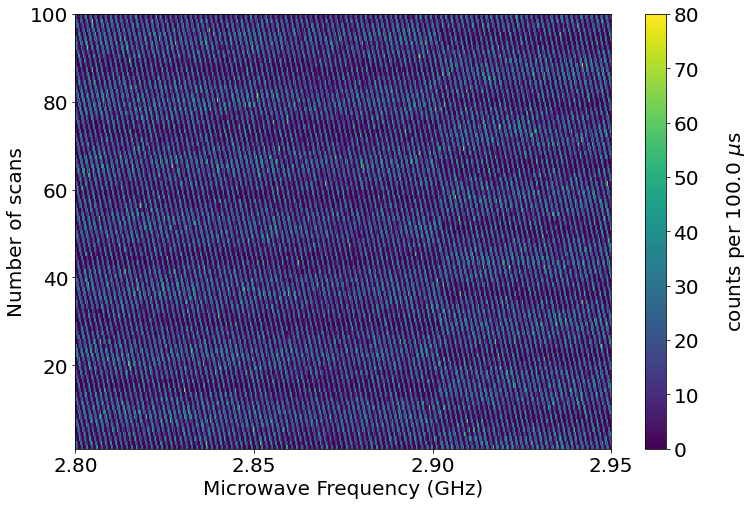

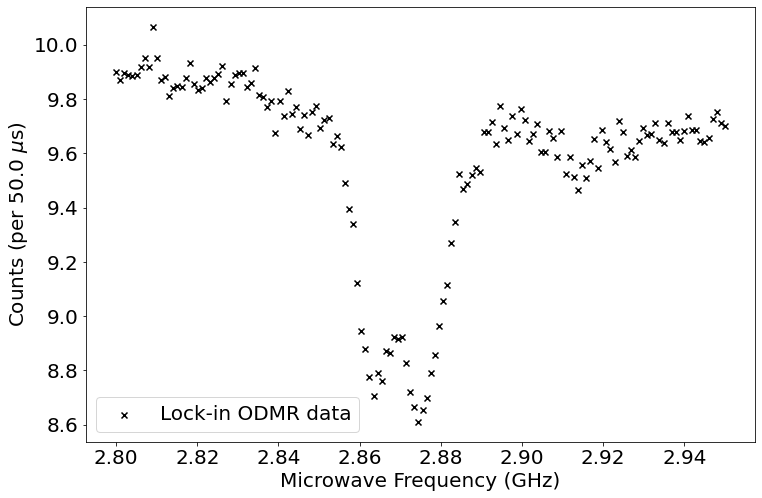

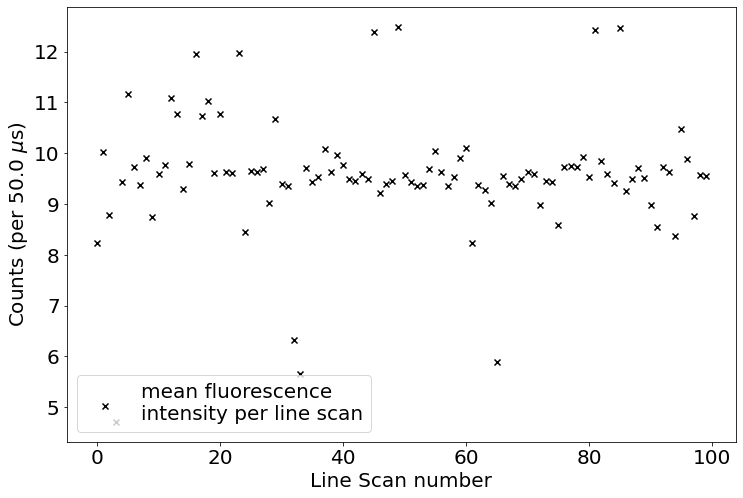

In [15]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20210303'
file_name = date + '_NVScan_03'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

pixel_dwell_time = params_values[3] # Pixel Dwell time in microseconds
microwave_dwell_time = params_values[6] # Microwave Dwell time in microseconds
mod_freq = params_values[7] # AOM modulation frequnecy.

fig1, ax1 = plot_heat_map(freq, odmr_data, pixel_dwell_time)

if mod_freq == 0:
    demod_odmr = pd.DataFrame(np.transpose(odmr_data))
else:
    # demodulate the signal
    demod_odmr = demodulate_signal(odmr_data, mod_freq, pixel_dwell_time)

# Perform Low-pass filtering (averaging)
lpf_odmr = low_pass_filter(demod_odmr, mod_freq, microwave_dwell_time, pixel_dwell_time)

fig2, ax2, freq = plot_lpf_signal(params_values[0], params_values[1], pixel_dwell_time, lpf_odmr)

fig3, ax3 = drift_check_plot(lpf_odmr, pixel_dwell_time)

#save_data(date, file_name, freq, lpf_odmr.mean(axis = 1), pixel_dwell_time, fig1, fig2, fig3)

In [51]:
print(demod_odmr[0])

0       165.0
1       210.0
2       189.0
3       243.0
4       188.0
        ...  
2496    199.0
2497    164.0
2498    260.0
2499    236.0
2500    168.0
Name: 0, Length: 2501, dtype: float64


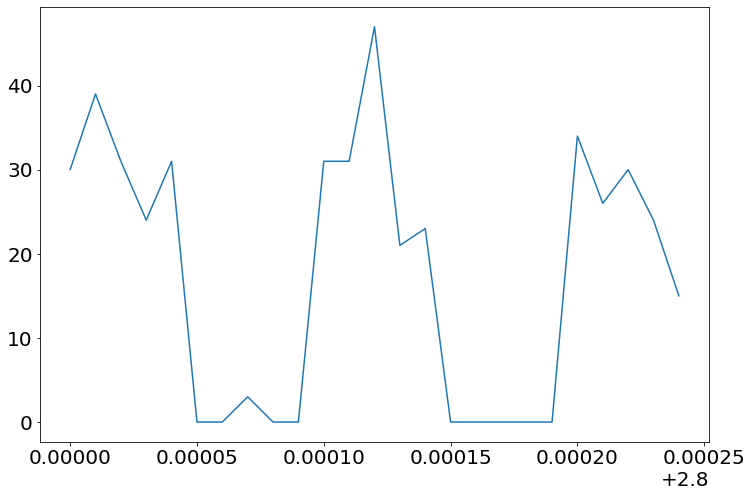

In [16]:
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])
plot.plot(freq[0:25], odmr_data[0][0:25])

In [22]:
print(odmr_data.shape)

(10, 12501)


In [21]:
print(freq)

[2.75    2.75002 2.75004 ... 2.99996 2.99998 3.     ]
